In [9]:
import os
import numpy as np
import seaborn as sns

from vae import Sampling, VAE

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
(_, _), (x_test, _) = keras.datasets.mnist.load_data(path=os.path.expanduser('~/dev/data/mnist/mnist.npz'))

In [3]:
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [5]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [6]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.load_weights('./results/model_04/vae_weights')
# vae.load_weights('./tmp/vae_weights')

In [7]:
z_mean, z_log_var, z = vae.encoder(x_test)

reconstruction = vae.decoder(z_mean)
reconstruction_errors = tf.reduce_mean(keras.losses.mean_squared_error(x_test, reconstruction), axis=(1, 2))

In [7]:
prioritization = np.argsort(reconstruction_errors)[::-1]

np.save('./tmp/vae.npy', prioritization)

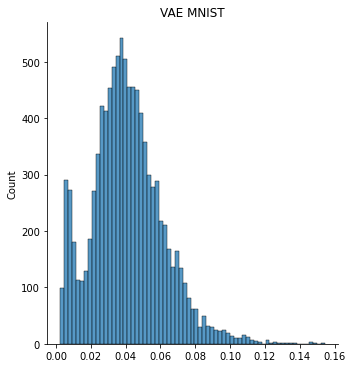

In [13]:
# plot the distribution of reconstruction errors

sns.displot(reconstruction_errors)
plt.title('VAE MNIST')
plt.savefig('./tmp/vae_mnist', bbox_inches='tight')
plt.show()